# Preparating Data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import  Pool

%matplotlib inline

In [2]:
# import variables of all process
sample_frac = 0.25
frac_nan_values = 0.05

#some important dicts
map_D63 = dict(zip(['CR', 'CO', 'CL', 'XL', 'XZ', 'XM'], range(6)))
map_D64 = dict(zip(['O', 'R', np.nan, 'U', '-1'], [0, 1, np.nan, 2, 3]))
columns_dtype = {'B_31' : 'int8', **json.load(open('columns_map.json'))}
columns_to_drop = ['S_3', 'D_42', 'D_43', 'D_46', 'D_48', 'D_49', 'D_50', 'D_53',
                   'S_7', 'D_56', 'S_9', 'D_62', 'B_17', 'D_66', 'D_73', 'D_76',
                   'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106',
                   'R_26', 'R_27', 'D_108', 'D_110', 'D_111', 'B_39', 'S_27', 'B_42',
                   'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142','S_2']


# Reading data in chunks
all_columns = list(pd.read_csv('C:/Users/DavidG/Documents/american_express_data/train_data.csv', nrows =1))
columns_to_read = np.setdiff1d(all_columns, columns_to_drop)
train_result = pd.read_csv('C:/Users/DavidG/Documents/american_express_data/train_labels.csv', dtype = {'target': 'int8'}) # Read the result of train data

train_partitions = np.array_split(train_result.sample(frac = 1, random_state = 12345), int(1/sample_frac))


#print("Fraction of 1 in the complete dataset is {}".format(sum(train_result['target'])/len(train_result))) # Showing the fraction of 1 in the all data
#print("Fraction of 1 in the sample dataset is {}".format(sum(train_result_sample['target'])/len(train_result_sample))) # Showing the fraction of 1 in the sample data

In [3]:
n = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
div_val = n*((n*n).cumsum()) - (n.cumsum())**2
div = dict(zip(n, div_val))
div = {0:np.nan, **div}
div[1] = np.nan
sum_val = dict(zip(n, n.cumsum()))
sum_val = {0:np.nan, **sum_val}

for k, partition in enumerate(train_partitions):
    train_data = pd.read_csv('C:/Users/DavidG/Documents/american_express_data/train_data.csv', chunksize = 500000, dtype = columns_dtype, usecols = columns_to_read)
    train_result_sample = partition
    chunk_list = []
    for chunk in train_data:
        chunk_list.append(pd.merge(train_result_sample, chunk, how = 'inner', on = 'customer_ID'))

    train_data_sample = pd.concat(chunk_list)


    del chunk_list
    print('Ready the lecture of {} partition'.format(k))
    
    
    train_data_sample['D_63'] = train_data_sample.apply(lambda x: map_D63[x['D_63']], axis = 1)
    train_data_sample['D_64'] = train_data_sample.apply(lambda x: map_D64[x['D_64']], axis = 1)
    print('Ready apply of {} partition'.format(k))
    
    train_data_sample.reset_index(drop = True, inplace = True)
    train_data_sample['n'] = np.ones(len(train_data_sample), dtype = 'int8')
    j = 1
    for i in range(1, len(train_data_sample)):
        if train_data_sample.loc[(i-1, 'customer_ID')] == train_data_sample.loc[(i, 'customer_ID')]:
            j += 1
        else:
            j = 1
        train_data_sample.loc[(i, 'n')] = j
    cont_pd = train_data_sample.drop(['target', 'n'], axis = 1).groupby('customer_ID').count()
    print('Ready add n values of {} partition'.format(k))
    
    # m values
    m_values = train_data_sample.drop(['target', 'n', 'customer_ID'], axis = 1).multiply(train_data_sample['n'], axis = 0)
    m_values = m_values.astype('float32')
    m_values = pd.concat([m_values, train_data_sample['customer_ID']], axis = 1)
    m_values = m_values.groupby('customer_ID').sum() * cont_pd
    m_values = m_values + cont_pd.applymap(lambda x: -sum_val[x])*train_data_sample.drop(['target', 'n'], axis = 1).groupby('customer_ID').prod()
    m_values = m_values.astype('float32')
    m_values = m_values / cont_pd.applymap(lambda x: div[x])
    m_values = m_values.astype('float32')
    print('Ready m_values of {} partition'.format(k))
    
    # Other features
    X_train = train_data_sample.drop(['target'], axis = 1).groupby('customer_ID').agg([np.mean, np.max, np.min, np.std])
    X_train = pd.DataFrame(data = X_train.values.astype('float32'), index = X_train.index, columns = [x[0] + '_' + x[1] for x in X_train.columns])
    X_train = pd.merge(X_train, m_values, how = 'inner', left_index = True, right_index = True)
    final_data_dropna = pd.merge(X_train.dropna(), train_result_sample, on = 'customer_ID', how = 'inner')
    final_data_fillna = pd.merge(X_train.fillna(X_train.mean()), train_result_sample, on = 'customer_ID', how = 'inner')
    final_data_dropna.to_parquet('C:/Users/DavidG/Documents/american_express_data/dropna_data_{}.parquet'.format(k))
    final_data_fillna.to_parquet('C:/Users/DavidG/Documents/american_express_data/fillna_data_{}.parquet'.format(k))
    print('Ready other features of {} partition and save'.format(k))
    
    # Eliminate variables
    del m_values
    del X_train
    del train_data_sample
    del train_result_sample
    del cont_pd
    del final_data_dropna
    del final_data_fillna

Ready the lecture of 0 partition
Ready apply of 0 partition
Ready add n values of 0 partition
Ready m_values of 0 partition
Ready other features of 0 partition and save
Ready the lecture of 1 partition
Ready apply of 1 partition
Ready add n values of 1 partition
Ready m_values of 1 partition
Ready other features of 1 partition and save
Ready the lecture of 2 partition
Ready apply of 2 partition
Ready add n values of 2 partition
Ready m_values of 2 partition
Ready other features of 2 partition and save
Ready the lecture of 3 partition
Ready apply of 3 partition
Ready add n values of 3 partition
Ready m_values of 3 partition
Ready other features of 3 partition and save


In [4]:
n = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
div_val = n*((n*n).cumsum()) - (n.cumsum())**2
div = dict(zip(n, div_val))
div = {0:np.nan, **div}
div[1] = np.nan
sum_val = dict(zip(n, n.cumsum()))
sum_val = {0:np.nan, **sum_val}
train_data_sample.reset_index(drop = True, inplace = True)
train_data_sample['n'] = np.ones(len(train_data_sample), dtype = 'int8')
j = 1
for i in range(1, len(train_data_sample)):
    if train_data_sample.loc[(i-1, 'customer_ID')] == train_data_sample.loc[(i, 'customer_ID')]:
        j += 1
    else:
        j = 1
    train_data_sample.loc[(i, 'n')] = j

In [6]:
cont_pd = train_data_sample.drop(['target', 'n'], axis = 1).groupby('customer_ID').count()

# m values
m_values = train_data_sample.drop(['target', 'n', 'customer_ID'], axis = 1).multiply(train_data_sample['n'], axis = 0)
m_values = m_values.astype('float32')
m_values = pd.concat([m_values, train_data_sample['customer_ID']], axis = 1)
m_values = m_values.groupby('customer_ID').sum() * cont_pd
m_values = m_values + cont_pd.applymap(lambda x: -sum_val[x])*train_data_sample.drop(['target', 'n'], axis = 1).groupby('customer_ID').prod()
m_values = m_values.astype('float32')
m_values = m_values / cont_pd.applymap(lambda x: div[x])
m_values = m_values.astype('float32')

# Other features
X_train = train_data_sample.drop(['target'], axis = 1).groupby('customer_ID').agg([np.mean, np.max, np.min, np.std])
X_train = pd.DataFrame(data = X_train.values.astype('float32'), index = X_train.index, columns = [x[0] + '_' + x[1] for x in X_train.columns])
X_train = pd.merge(X_train, m_values, how = 'inner', left_index = True, right_index = True)
final_data_dropna = pd.merge(X_train.dropna(), train_result_sample, on = 'customer_ID', how = 'inner')
final_data_fillna = pd.merge(X_train.fillna(X_train.mean()), train_result_sample, on = 'customer_ID', how = 'inner')

# Eliminate variables
del m_values
del X_train
del train_data_sample
del train_result_sample
del cont_pd

In [119]:
# Section only for select columns too empty
#columns = []
#nan_values = []
#for column in train_data_sample.columns:
#    try:
#        nan_value = np.sum(np.isnan(train_data_sample[column]))
#        if nan_value != 0:
#            columns.append(column)
#            nan_values.append(nan_value)
#    except:
        ;
#columns_with_nan = pd.DataFrame(data = nan_values, index = columns)
#columns_to_drop = columns_with_nan[columns_with_nan[0] > len(train_data_sample)*frac_nan_values].index.values
#train_data_sample.drop(labels = columns_to_drop, axis = 1, inplace = True)

In [8]:
X_train = final_data_fillna.drop(['customer_ID', 'target'], axis = 1)
y_train = final_data_fillna['target']

In [9]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)
    print("g value is {} and d value is {}".format(g, d))

    return 0.5 * (g + d)

In [10]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, random_state=0) 
sc = StandardScaler() 
x_train_2 = sc.fit_transform(x_train_2)
x_test_2 = sc.transform(x_test_2) 
#pca = PCA(n_components = 60).fit(x_train_2)
#x_train_2 = pca.transform(x_train_2)
#x_test_2 = pca.transform(x_test_2)
#mds = MDS(n_components = 20)
#x_train_2 = mds.fit_transform(x_train_2)
#x_test_2 = mds.transform(x_test_2)

#tsne = TSNE(random_state = 0)

#x_train_2 = tsne.fit_transform(x_train_2)
#x_test_2 = tsne.transform(x_test_2)

In [11]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, 
                           eval_metric = 'auc', max_depth = 3, learning_rate = 0.2, gamma = 0.1)
xgb_clf.fit(x_train_2, y_train_2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [12]:
y_predict = xgb_clf.predict(x_test_2)
y_predict_proba = xgb_clf.predict_proba(x_test_2)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_2, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test_2, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test_2, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test_2, y_predict)))
print(amex_metric(pd.DataFrame(y_test_2), pd.DataFrame(y_predict_proba, index = y_test_2.index, columns = ['prediction'])))

Accuracy: 0.89
Precision: 0.79
Recall: 0.78
F1: 0.79
g value is 0.9047781436540279 and d value is 0.5964209401709402
0.750599541912484


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

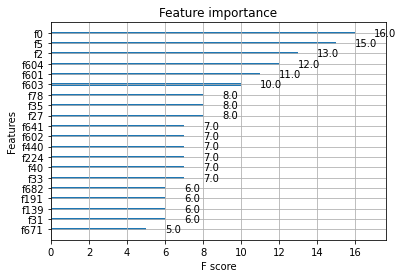

In [99]:
#plt.barh(xgb_clf.feature_names, xgb_clf.feature_importances_)
from xgboost import plot_importance
plot_importance(xgb_clf, max_num_features =20)

In [132]:
logreg = LogisticRegression(max_iter = 1000, C = 0.05, class_weight = [1, 95]).fit(x_train_2, y_train_2)

In [133]:
y_predict = logreg.predict(x_test_2)
y_predict_proba = logreg.predict_proba(x_test_2)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_2, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test_2, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test_2, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test_2, y_predict)))
print(amex_metric(pd.DataFrame(y_test_2), pd.DataFrame(y_predict_proba, index = y_test_2.index, columns = ['prediction'])))

Accuracy: 0.89
Precision: 0.80
Recall: 0.76
F1: 0.78
g value is 0.9013565607802082 and d value is 0.6090353260869565
0.7551959434335824


In [105]:
#from sklearn.model_selection import GridSearchCV
#logreg_2 = LogisticRegression(max_iter = 1000)
#grid_values = {'C': [0.1, 0.5, 1, 10],
#               'class_weight' : ['balanced', None]}

# default metric to optimize over grid parameters: accuracy
#grid_clf_acc = GridSearchCV(logreg_2, param_grid = grid_values)
#grid_clf_acc.fit(x_train_2, y_train_2)

In [ ]:
svcrbf = SVC(kernel = 'rbf', probability = True).fit(x_train_2, y_train_2)

In [ ]:
y_predict = svcrbf.predict(x_test_2)
y_predict_proba = svcrbf.predict_proba(x_test_2)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_2, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test_2, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test_2, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test_2, y_predict)))
print(amex_metric(pd.DataFrame(y_test_2), pd.DataFrame(y_predict_proba, index = y_test_2.index, columns = ['prediction'])))

In [16]:
prob_data = pd.read_parquet('C:/Users/DavidG/Documents/american_express_data/data_1.parquet')

In [20]:
'C:/Users/DavidG/Documents/american_express_data/data_{}.parquet'.format(2)

'C:/Users/DavidG/Documents/american_express_data/data_2.parquet'

In [21]:
prob_data

,customer_ID,P_2_mean,P_2_amax,P_2_amin,P_2_std,D_39_mean,D_39_amax,D_39_amin,D_39_std,B_1_mean,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,1.005816,1.009762,1.000488,0.003309,0.353440,0.560899,0.000811,0.215033,0.062956,...,0.002532,0.002378,0.003190,0.002260,0.002570,0.002070,0.002356,0.002590,0.002924,0
1,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.374289,0.612548,0.254523,0.206339,0.084755,0.241415,0.005258,0.135677,0.108588,...,2.003728,1.107959,0.016179,1.998605,0.013047,1.956557,1.997741,0.016679,0.283608,1
2,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,0.386107,0.431697,0.340604,0.031185,0.117855,0.354380,0.000871,0.134075,0.862294,...,0.002099,0.001926,0.002715,0.002453,0.002428,0.003137,0.002443,0.002132,0.001712,1
3,00039533fe0b61bcf1ec0d1aefe6acb5469ea0f0d1b0ad...,0.247794,0.313965,0.150654,0.053293,0.025080,0.093875,0.003542,0.024725,0.602409,...,0.001975,0.002823,0.002838,0.002664,0.002145,0.002585,0.001890,0.002043,0.002612,1
4,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,0.825571,0.839217,0.776110,0.018486,0.113482,0.564188,0.001599,0.198287,0.014267,...,0.002905,0.002770,0.001816,0.002356,0.002720,0.003437,0.002564,0.002707,0.002637,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114724,fffc9005dae01b2c79a168c6562144220657b28b8f1bf4...,0.746232,0.755517,0.723696,0.009455,0.004974,0.009215,0.000739,0.003228,0.004776,...,0.002444,0.002751,0.002757,0.002368,0.001774,0.002850,0.002961,0.002914,0.002407,0
114725,fffdc0cf228085b4275b38ebe6eb915766af3fecb2ae28...,0.964291,0.994921,0.886337,0.032537,0.246970,0.591984,0.001412,0.199295,0.044627,...,0.002712,0.002248,0.002633,0.002179,0.002513,0.002908,0.002061,0.003014,0.002562,0
114726,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,0.726345,0.885434,0.629187,0.093502,0.008404,0.039272,0.000581,0.013202,0.012062,...,0.001576,0.001538,0.002466,0.002321,0.001993,0.003453,0.002695,0.002955,0.003103,0
114727,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,0.304604,0.370313,0.229116,0.044657,0.143390,0.361938,0.088934,0.082065,0.576485,...,0.460551,0.135116,0.002146,0.002262,0.003207,0.002761,0.002565,0.002018,0.002984,0
